
Imports & magic


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Data pipeline  0-1 scaled

In [24]:
def preprocess(img, lbl):
    img = tf.cast(img, tf.float32) / 255.0
    return img, lbl

train_ds, test_ds = tfds.load('fashion_mnist',
                              split=['train', 'test'],
                              as_supervised=True,
                              shuffle_files=True)

BATCH = 128
AUTO = tf.data.AUTOTUNE

train_ds = (train_ds.shuffle(60000)
            .map(preprocess, AUTO)
            .batch(BATCH)
            .prefetch(AUTO))

# 5 k validation
val_ds   = train_ds.unbatch().take(5000).batch(BATCH).prefetch(AUTO)
train_ds = train_ds.unbatch().skip(5000).batch(BATCH).prefetch(AUTO)
test_ds  = (test_ds.map(preprocess, AUTO)
            .batch(BATCH)
            .prefetch(AUTO))

class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

ResNet-20 building blocks

In [25]:
def res_block(x, filters, stride=1):
    shortcut = x
    # 1st conv
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # 2nd conv
    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # shortcut projection if shapes differ
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

ResNet-20 model (3 stages × 3 blocks = 9 blocks → 18 convs + 1 first + 1 final = 20 weight layers)


In [26]:
def ResNet20():
    inputs = layers.Input(shape=(28,28,1))
    # first conv: keep 28×28
    x = layers.Conv2D(16, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # stage 1  (16 filters, 3 blocks)
    for _ in range(3):
        x = res_block(x, 16, stride=1)

    # stage 2  (32 filters, down-sample 28→14)
    x = res_block(x, 32, stride=2)
    for _ in range(2):
        x = res_block(x, 32, stride=1)

    # stage 3  (64 filters, down-sample 14→7)
    x = res_block(x, 64, stride=2)
    for _ in range(2):
        x = res_block(x, 64, stride=1)

    # global average → 64 numbers
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10)(x)        # logits
    return models.Model(inputs, outputs)

model = ResNet20()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │        160 │ input_layer_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │      2,320 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 28, 28,    │      2,320 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 28,    │      2,320 │ re_lu_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 28, 28,    │      2,320 │ re_lu_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 274,538 (1.05 MB)

 Trainable params: 272,970 (1.04 MB)

 Non-trainable params: 1,568 (6.12 KB)

Compile with LR schedule

In [27]:
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.5, patience=3, verbose=1,
                                          min_lr=1e-5)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train

In [28]:
EPOCHS = 25
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[lr_schedule],
                    verbose=2)

Epoch 1/25
430/430 - 44s - 102ms/step - accuracy: 0.8337 - loss: 0.4517 - val_accuracy: 0.5540 - val_loss: 1.6336 - learning_rate: 1.0000e-03
Epoch 2/25
430/430 - 10s - 22ms/step - accuracy: 0.9030 - loss: 0.2679 - val_accuracy: 0.8612 - val_loss: 0.4024 - learning_rate: 1.0000e-03
Epoch 3/25
430/430 - 11s - 25ms/step - accuracy: 0.9181 - loss: 0.2266 - val_accuracy: 0.8444 - val_loss: 0.4206 - learning_rate: 1.0000e-03
Epoch 4/25
430/430 - 10s - 22ms/step - accuracy: 0.9281 - loss: 0.1994 - val_accuracy: 0.8774 - val_loss: 0.3427 - learning_rate: 1.0000e-03
Epoch 5/25
430/430 - 10s - 22ms/step - accuracy: 0.9335 - loss: 0.1826 - val_accuracy: 0.9214 - val_loss: 0.2093 - learning_rate: 1.0000e-03
Epoch 6/25
430/430 - 10s - 23ms/step - accuracy: 0.9414 - loss: 0.1640 - val_accuracy: 0.9180 - val_loss: 0.2317 - learning_rate: 1.0000e-03
Epoch 7/25
430/430 - 9s - 22ms/step - accuracy: 0.9453 - loss: 0.1533 - val_accuracy: 0.9424 - val_loss: 0.1655 - learning_rate: 1.0000e-03
Epoch 8/25
43

Test Evaluation

In [29]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"ResNet-20 test accuracy = {test_acc*100:.1f} %")

ResNet-20 test accuracy = 92.8 %


Confusion matrix

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


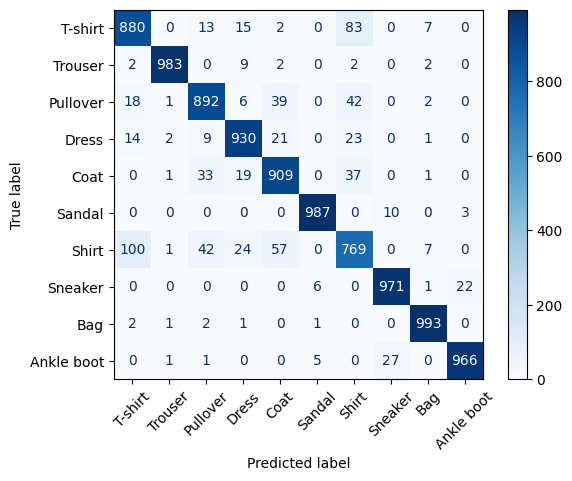

In [30]:
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()